In [1]:
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

#spice_library = SpiceLibrary("library/")

In [35]:
circuit = Circuit("JFET preamp")

v_phantom = circuit.V('phantom_power', 'vdd', circuit.gnd, 48@u_V)
r_l = circuit.R('1', 'vdd', 1, 6.81@u_kOhm)
r_r = circuit.R('2', 'vdd', 2, 6.81@u_kOhm)
r_load = circuit.R('load', 1, 2, 3@u_kOhm)

circuit.model('LSK489A', 'NJF', beta=2.2e-3, betatce=-.5, rd=11, rs=30, lambda_=4.3e-3, vto=-1.13, vtotc=-2.5e-3,
              is_=3e-15,
              isr=0, n=1, xti=0, alpha=30e-6, VK=120, Cgd=3.19e-12, Mj=0.32,
              Pb=0.8, Fc=0.5, Cgs=2.92e-12, Kf=0.0009e-15,
              Af=1, Gdsnoi=2.15, Nlev=3, Mfg='Linear_Systems')

q1 = circuit.JFET('q1', 1, 'g1', 3, model='LSK489A')
q2 = circuit.JFET('q2', 2, 'g2', 4, model='LSK489A')

rs1 = circuit.R('s1', 3, 5, 10@u_Ohm)
rs2 = circuit.R('s2', 4, 5, 10@u_Ohm)

rs = circuit.R('s', 5, circuit.gnd, 5@u_kOhm)

# gate biasing
rg1 = circuit.R('g1', 1, 'g1', 10@u_MOhm)
rg2 = circuit.R('g2', 2, 'g2', 10@u_MOhm)
rg3 = circuit.R('g3', circuit.gnd, 'g1', 10@u_MOhm)
rg4 = circuit.R('g4', circuit.gnd, 'g2', 10@u_MOhm)

cg1 = circuit.C('1', 'g1', 'cin1', 100@u_uF)
cg2 = circuit.C('2', 'g2', 'cin2', 100@u_uF)

rin1 = circuit.R('in1', 'cin1', 'in1', 0.5@u_MOhm)
rin2 = circuit.R('in2', 'cin2', 'in2', 0.5@u_MOhm)
vs = circuit.SinusoidalVoltageSource('input', 'in1', 'in2', amplitude=0.1@u_V, frequency=1e+3)
rt = circuit.R('tmp', 'in1', circuit.gnd, 5@u_MOhm)

In [36]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

#analysis = simulator.transient(step_time=1@u_us, end_time=1000@u_us)
analysis = simulator.operating_point()
analysis

In [37]:
tran_analysis = simulator.transient(step_time=1@u_us, end_time=1000@u_us)


In [38]:
analysis['g1'], analysis['5']/rs.resistance

(WaveForm g1 [17.85236544]@V, WaveForm  [0.00360743]@A)

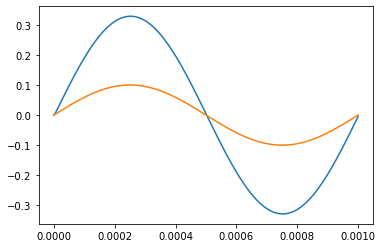

In [39]:
plt.plot(tran_analysis.time, tran_analysis['2']-tran_analysis['1'])
plt.plot(tran_analysis.time, tran_analysis['in1']-tran_analysis['in2'])

In [40]:
20*np.log10(float(np.std(tran_analysis['2']-tran_analysis['1'])/np.std(tran_analysis['in1']-tran_analysis['in2'])))

10.326951614171897

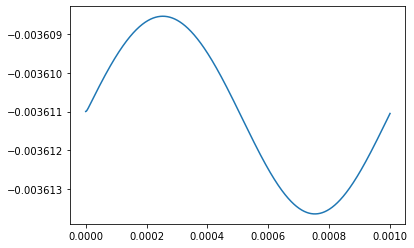

In [41]:
plt.plot(tran_analysis.time, tran_analysis.branches['vphantom_power'])

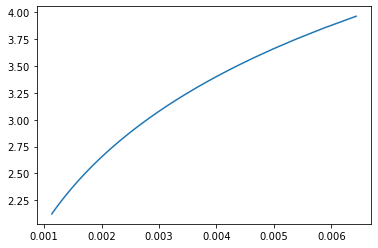

In [42]:
rs_tests = np.linspace(2, 20, 50)
gains = np.zeros(rs_tests.shape[0])
rs_i = np.zeros(rs_tests.shape[0])
for i, rs_t in enumerate(rs_tests):
    rs.resistance = rs_t@u_kOhm
    ta = simulator.transient(step_time=1@u_us, end_time=10000@u_us)
    gains[i] = float(np.std(ta['1']-ta['2'])/np.std(ta['in1']-ta['in2']))
    rs_i[i] = float(np.mean(ta['5'])/rs.resistance)

plt.plot(rs_i, gains)

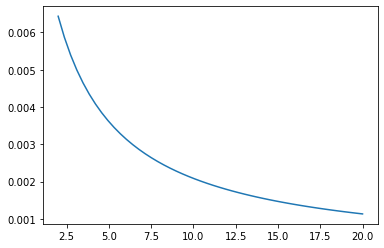

In [43]:
plt.plot(rs_tests, rs_i)